# Machine Learning

So this is a peripheral topic relative to most of the concepts we've studied so far this semester, but it's an increasingly important area of computational technology and it's important to be aware of emerging tools in case they might be useful for a problem you encounter in your work. The idea is to create mechanisms for a machine (computer) to "learn" from data. One type of machine learning is "supervised" learning, in which a series of "solved" cases is presented to the computer for "training". Once the computer achieves a certain level of skill in recognizing the solved cases, some "test" cases are presented and the result is validated (or not).

One of the most straightforward techniques for machine learning is inspired by the physiology of the nervous system. The idea is to create artificial "neurons" that collect input from the various places, add up those inputs with varying weights and produce an output that can be one of two values, say "yes"/"no" or "approved"/"denied" or whatever binary classification you like. Let's make this more concrete: Suppose we want to decide if a blossom belongs to a flower of a specific species. We'll use the famous [Fisher's Iris Data](https://en.wikipedia.org/wiki/Iris_flower_data_set). The "inputs" are the length and width of the petals and sepals from a sampling of blossoms of Iris flowers found in various cemeteries[1]. The inputs are labeled $x_i$, and the weights are $w_i$. The output from a particular blossom could be calculated as:

$$y = \sum_{i=1}^{n} w_i x_i \,\,\, (1)$$

The idea is that if $y$ is greater than some threshold value, then the output is "yes", otherwise it's "no".

The question is: "What should the weights be?" and "What should the threshold be?". 

The answer is: Whatever they need to be to make the thing work!

The game is to fiddle with the weights and the threshold until the output matches the known answer for some subset of the whole data (called the "training" set). Then the "quality" of the system can be evaluated using the remainder of the data set (called the "testing" set). There are two technical questions we need to address: Q1) What's the procedure to modify the weights to improve the predictions? and Q2) How do we keep track of the threshold value?

There are many ways to answer "Q1". The simplest answer is: come up with a measure of "error" for the prediction of the system for a specific input in the training set. We use that error from a particular input to "nudge" the weights slightly, then we iterate over the entire training set slowly improving (hopefully) the accuracy of the predictions in each pass through the various inputs. When the system stops improving, we can test the system using the "testing" set.

The issue with "Q2" is solved with a trick. Note that from Eq. 1 we get a value that is compared to some threshold. So the idea is:

* if $y$ is greater than (or equal to) some number, the answer is "yes"
    
* if $y$ is less than this number, the answer is "no"

However we could *subtract* the threshold value of $y$ from both sides of Eq. 1 and treat the threshold as just another weight by adding a "fake" input that's always just 1.0:

$$y = w_0 + \sum_{i=1}^{n} w_i x_i \,\,\, (2)$$

Finally, note that if we store the weights and inputs as numpy vectors it's easy to compute this sum as a "dot" product between the "weight vector" and the "input vector" for each item in the set.

First let's pull in pylab and pandas as usual. Let's start with a completely "fake" data set with only two inputs just to see how this works. We can visualize all the data in a 2D scatter plot.

    1. FISHER, R. A. (1936), THE USE OF MULTIPLE MEASUREMENTS IN TAXONOMIC PROBLEMS. Annals of Eugenics, 7: 179–188. doi:10.1111/j.1469-1809.1936.tb02137.x


In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Fake Data

Almost like fake news, fake data let's us make up things and try out ideas. It doesn't matter if it's really right or not, since it's all just fake! Suppose we're trying to predict if someone will want fries with their lunch. We ask "how much do you like salt?" and "how hungry are you?" The answers to these questions, on a 3 pt scale are collected, along with whether they ordered fries with their meeal:

Person | Likes Salt? | Hunger Level? | Ordered Fries?
:---:|:---:|:---:|:---:
1 | 1 | 1 | No
2 | 1 | 2 | No
3 | 2 | 1 | No
4 | 2 | 2 | Yes
5 | 2 | 3 | Yes
6 | 3 | 2 | Yes
7 | 0.3 | 0.5 | No
8 | 2.5 | 2.5 | Yes

The input data is used for the `x` array, and the output data is converted to `+1` and `-1` 
for the output array.


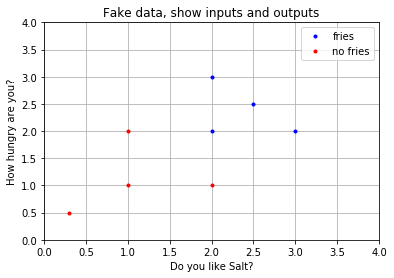

In [2]:

x = array([  # x is an Nx3 (x[0] is always 1, for the threshold, x[1], and x[2]
    [1,1,1], # are the "real" inputs that correspond to actual data.
    [1,1,2], # For example x[1] could be 
    [1,2,1],
    [1,2,2],
    [1,2,3],
    [1,3,2],
    [1,0.3,0.5],
    [1,2.5,2.5],
])

y = array([-1,-1,-1,1,1,1,-1,1])  # did they order fries? +1 -> yes, and -1 -> no.

xlim(0,4)                 # plot x from 0 to 4
ylim(0,4)                 # plot y from 0 to 4

ix_fries = (y==1)              # boolean, do you like fries?
ix_no_fries = invert(ix_fries) # boolean, inverse of ix_fries?

title("Fake data, show inputs and outputs")
xlabel("Do you like Salt?")
ylabel("How hungry are you?")
plot(x[ix_fries,1],x[ix_fries,2],'b.',label="fries")
plot(x[ix_no_fries,1],x[ix_no_fries,2],'r.',label="no fries")
legend()
grid()

# Calculating Error and updating weights

Let's look at a simple implementation of updating weights and calculating error.

Suppose we have an array `w` that contains the weights and we wish to compute the sum from Eq 1 for the `j`th row fo the 2D array `x`. It's easy using the `dot` method of linear algebra:

    y_out = x[j].dot(w)
    
This will give us a scaler value. If the scaler is greater than, or equal to 0 we want to register that as a "yes", and if it's below zero it's a "no". The easiest way to track error is to use a numerical representation of "yes" and "no". For this exercise let's use `+1` for "yes" and `-1` for "no" (just like the y array).

There's a paradigm in python, similar to the `c` trick: `cond ? a:b` in python that's:

    cond and a or b
    
Note that python only evaluates the second operand when evaluating an `and` operation if the first operand is `True`. Also, python always evaluates the second operand in an `or` operation if the first operand is `False`. So the statement 

    cond and a or b

will return `a` if `cond` is true and `b` if `cond` is false. So, we can get what we want using:

    y_out = (x[j].dot(w)>=0.0) and +1 or -1
    
This compares `x[j].dot(w)` to zero, and returns `+1` or `-1` if the result is above or below zero respectively.

So, below find three functions defined, the workhorse `calc_error` which evaluates the error and (optionally) updates the weights as well as `test` and `train` which call `calc_error` to test and train the system, respectively.

The only non-trivial part of `calc_error` is the updating of the weights which looks like this:

    w += eta*err*x[j]
    
`x[j]` is the jth input. `err` is the calculated error (+2 if the output is low, -2 if the output is high, and 0 if the output matches the input). Note that if the output is low and a particular input is *positive*, this will *increase* the weight for that input thereby increasing the output for this input in the future. On the other hand if the input is *negative* this will decrease the weight of that input, also increasing the output for this input in the future. So the *sign* of the inputs is automatically taken into account with this update formula.


In [3]:
def calc_error(y_arr, x_arr, w, train=False):
    """
    calc_error computes the error for each input (+1 if it's wrong, 0 if it's correct)
    
    y_arr is the 1D array of known outputs
    x_arr is the 2D array of inputs (N rows (number of samples), m+1 columns (number of inputs/sample))
    w is the 1D array of weights (threshold + m weights)
    train is True if training (updating of weights) is to occur as a side effect.

    Returns: The total number of errors found in iterating over all the samples
    """
    
    err_sum=0.0
    for j in range(len(y_arr)):
        y_out = (x_arr[j].dot(w)>=0.0) and 1 or -1  # make a prediction, +1 (versi) or -1 (vir)
        err = y_arr[j]-y_out                        # compare to known species
        err_sum += abs(err) and 1 or 0              # accumulate the total error
        if train:
            w += eta*err*x_arr[j]                   # adjust the weights during training only
    return err_sum
    
def train(y, x, w):
    return calc_error(y, x, w, train=True)

def test(y, x, w):
    return calc_error(y, x, w)

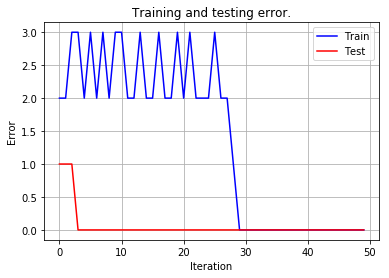

In [4]:
eta=0.1 # how much should we "nudge" the weights each time?
w = rand(len(x[0]))*.05  # random array of "small" weights

err_test=[]
err_train=[]
train_iters=50
for i in range(train_iters):
    err_train.append(train(y[:6], x[:6], w))
    err_test.append(test(y[6:], x[6:], w))

title("Training and testing error.")
plot(range(train_iters),err_train,'b', label="Train")
plot(range(train_iters),err_test,'r', label="Test")
xlabel("Iteration")
ylabel("Error")
legend()
grid()


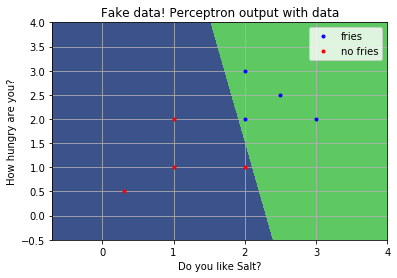

In [5]:
xx,yy = meshgrid(linspace(min(x[:,1])-1,max(x[:,1]+1),100),
                 linspace(min(x[:,2])-1,max(x[:,2]+1),100))

z=w[0]+xx*w[1] + yy*w[2]

contourf(xx,yy,z,levels=[-10,0,+10])

title("Fake data! Perceptron output with data")
xlabel("Do you like Salt?")
ylabel("How hungry are you?")

plot(x[ix_fries,1],x[ix_fries,2],'b.',label="fries")
plot(x[ix_no_fries,1],x[ix_no_fries,2],'r.',label="no fries")
legend()
grid()

So you can see the system "learned" to distinguish between "fries" and "no fries" by finding a linear separation guided by the "training" data. 

Next let's pull in some data from the "Iris" dataset described above.


In [6]:
df = pd.read_csv('Iris.csv')  # load the Iris dataset

In [7]:
df.head()  # look at the columns

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [8]:
df.Species.unique()  # what species are available in the dataset?

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Let's pull out only two species and take 80% for our training set and leave the rest for testing.

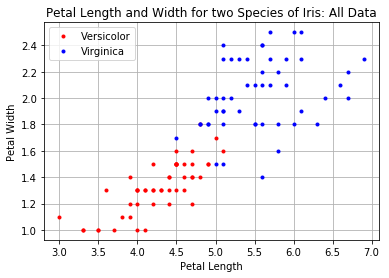

In [9]:
sub_frame = df[(df['Species']=='Iris-versicolor')|(df['Species']=='Iris-virginica')] # only two species
train_ix = rand(len(sub_frame))<0.8   # an array of random booleans, 80% true
train_df = sub_frame[train_ix]        # choose a random "training" set using the random index
test_df = sub_frame[invert(train_ix)] # use the rest for "testing".

#
# x is a 5xN (~80 samples with 4 traits + offset in column 1)
#
x=array([
    ones(len(train_df)),
    train_df.PetalLengthCm.values,
    train_df.PetalWidthCm.values,
    train_df.SepalLengthCm.values,
    train_df.SepalWidthCm.values,]).T  # transpose to get in the right shape

#
# y is an Nx1, +1 if species == versi and -1 otherwise
#

y=where(train_df.Species=='Iris-versicolor',1,-1)

#
# build testing set arrays, just like training set, but using the remaining indexes
#

xt=array([
    ones(len(test_df)),
    test_df.PetalLengthCm.values,
    test_df.PetalWidthCm.values,
    test_df.SepalLengthCm.values,
    test_df.SepalWidthCm.values,]).T

yt=where(test_df.Species=='Iris-versicolor',1,-1)

#
# Now plot all the data to visualize what we're seeing
#

versi_df=sub_frame[sub_frame.Species=='Iris-versicolor'] # get all the versi
virg_df=sub_frame[sub_frame.Species=='Iris-virginica']   # get all the virg

plot(versi_df.PetalLengthCm.values, versi_df.PetalWidthCm.values, 'r.', label="Versicolor")
plot(virg_df.PetalLengthCm.values, virg_df.PetalWidthCm.values, 'b.', label="Virginica")

xlabel("Petal Length")
ylabel("Petal Width")
title("Petal Length and Width for two Species of Iris: All Data")
legend(loc=2)
grid()

Test performance: 0.904762 with 21 samples


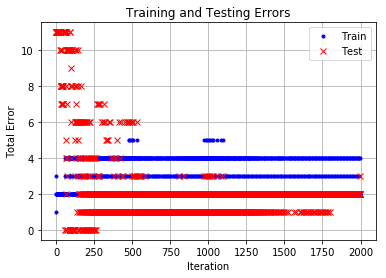

In [10]:
w = rand(len(x[0]))*.05  # random array of "small" weights

err_test=[]
err_train=[]
train_iters=2000
for i in range(train_iters):
    err_train.append(train(y, x, w))
    err_test.append(test(yt, xt, w))

title("Training and Testing Errors")
plot(range(train_iters),err_train,'b.',label="Train")
plot(range(train_iters),err_test,'rx',label="Test")
ylabel("Total Error")
xlabel("Iteration")
legend()
grid()

print("Test performance: %f with %d samples" % ((1.0 - err_test[-1]/len(yt)),len(yt)))

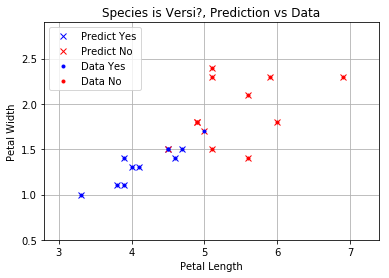

In [11]:
vals=[]
for i in range(len(xt)):
    vals.append((xt[i,1],xt[i,2],xt[i].dot(w),yt[i]))
z=array(vals,).T
gr=z[2]>=0.0
lt=invert(gr)
plot(z[0,gr],z[1,gr],'bx',label="Predict Yes") # show predictions of model with red and blue 'x's
plot(z[0,lt],z[1,lt],'rx',label="Predict No")
gr=z[3]>=0.0
lt=invert(gr)

xlim(min(xt[:,1])-.5,max(xt[:,1])+.5)
ylim(min(xt[:,2])-.5,max(xt[:,2])+.5)

plot(z[0,gr],z[1,gr],'b.',label="Data Yes") # show actual data with red and blue dots
plot(z[0,lt],z[1,lt],'r.',label="Data No")
legend(loc=2)
xlabel("Petal Length")
ylabel("Petal Width")
title("Species is Versi?, Prediction vs Data")
grid()

# What am I supposed to do?

For this project you can use the "Titanic" data to build a machine learning system that predicts whether or not a particular passenger on the Titanic will survive. You can use any of the parameters in the data you like. You'll need to convert non-numeric data into something numerical or categorical (multiple boolean inputs, see "one hot encoding").

OR you can grab any old data you like, even conduct a survey, and use that to build a system to predict anything you find interesting. So long as you incorporate the ideas introduced here, it's OK!



# What am I supposed to do (Option B):

This is just like option "A", but using TensorFlow rather than the simplified "perceptron" model.

See the TensorFlow [example notebook](P12b-MLTensorFlow.ipynb) in this repository.


